# Submission Visualization

This notebook provides comprehensive visualization of the MILK10k submission predictions including:
1. Class distribution analysis
2. Multi-label analysis
3. Co-occurrence patterns
4. Sample images with predictions


In [1]:
# Setup and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import sys

# Add src to path for config
sys.path.append('../src')
from config import DIAGNOSIS_CATEGORIES, TEST_INPUT_DIR, RESULTS_DIR, DATASET_DIR

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
%matplotlib inline


In [2]:
# Load submission data
submission_path = RESULTS_DIR / 'submission.csv'
submission_df = pd.read_csv(submission_path)

print(f"Submission shape: {submission_df.shape}")
print(f"Total lesions: {len(submission_df):,}")
print(f"\nColumns: {list(submission_df.columns)}")
print(f"\nFirst 5 rows:")
submission_df.head()


Submission shape: (479, 12)
Total lesions: 479

Columns: ['lesion_id', 'AKIEC', 'BCC', 'BEN_OTH', 'BKL', 'DF', 'INF', 'MAL_OTH', 'MEL', 'NV', 'SCCKA', 'VASC']

First 5 rows:


lesion_id  AKIEC  BCC  BEN_OTH  BKL  DF  INF  MAL_OTH  MEL  NV  SCCKA  \
0  IL_0006205      0    1        0    0   0    0        0    0   0      0   
1  IL_0025400      1    0        0    0   0    0        0    0   0      0   
2  IL_0039001      0    0        0    0   0    0        0    0   1      0   
3  IL_0046799      0    0        0    0   0    0        0    0   0      1   
4  IL_0054262      0    0        0    0   1    0        0    0   0      0   

   VASC  
0     0  
1     0  
2     0  
3     0  
4     0

In [3]:
# Full names for diagnosis categories
DIAGNOSIS_FULL_NAMES = {
    'AKIEC': 'Actinic keratosis / Intraepidermal carcinoma',
    'BCC': 'Basal cell carcinoma',
    'BEN_OTH': 'Other benign proliferations',
    'BKL': 'Benign keratinocytic lesion',
    'DF': 'Dermatofibroma',
    'INF': 'Inflammatory and infectious conditions',
    'MAL_OTH': 'Other malignant proliferations',
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevus',
    'SCCKA': 'Squamous cell carcinoma / Keratoacanthoma',
    'VASC': 'Vascular lesions and hemorrhage'
}

# Define malignant vs benign categories for color coding
MALIGNANT_CLASSES = ['AKIEC', 'BCC', 'MAL_OTH', 'MEL', 'SCCKA']
BENIGN_CLASSES = ['BEN_OTH', 'BKL', 'DF', 'NV', 'VASC']
OTHER_CLASSES = ['INF']  # Neither strictly benign nor malignant

print("Diagnosis categories loaded successfully!")


Diagnosis categories loaded successfully!


## 1. Class Distribution Analysis

Visualize how predictions are distributed across the 11 diagnosis categories.


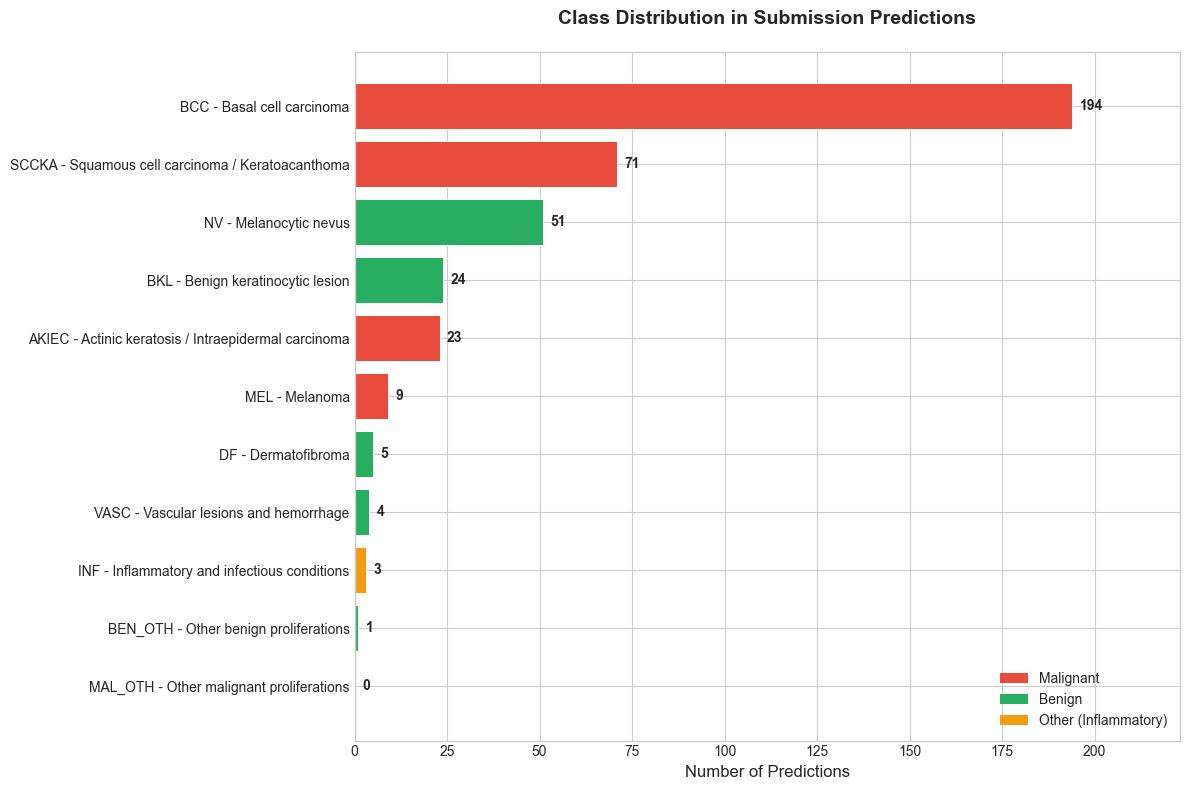


📊 Class Distribution Summary:
Class         Count   Percentage
--------------------------------
BCC             194        40.5%
SCCKA            71        14.8%
NV               51        10.6%
BKL              24         5.0%
AKIEC            23         4.8%
MEL               9         1.9%
DF                5         1.0%
VASC              4         0.8%
INF               3         0.6%
BEN_OTH           1         0.2%
MAL_OTH           0         0.0%


In [4]:
# Calculate class counts
class_counts = submission_df[DIAGNOSIS_CATEGORIES].sum().sort_values(ascending=True)

# Create color mapping based on malignant/benign/other
colors = []
for cls in class_counts.index:
    if cls in MALIGNANT_CLASSES:
        colors.append('#e74c3c')  # Red for malignant
    elif cls in BENIGN_CLASSES:
        colors.append('#27ae60')  # Green for benign
    else:
        colors.append('#f39c12')  # Orange for other (INF)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 8))

y_labels = [f"{cls} - {DIAGNOSIS_FULL_NAMES[cls]}" for cls in class_counts.index]
bars = ax.barh(y_labels, class_counts.values, color=colors, edgecolor='white', linewidth=0.7)

# Add value labels on bars
for bar, count in zip(bars, class_counts.values):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
            f'{int(count)}', va='center', fontsize=10, fontweight='bold')

# Styling
ax.set_xlabel('Number of Predictions', fontsize=12)
ax.set_title('Class Distribution in Submission Predictions', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, class_counts.max() * 1.15)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Malignant'),
    Patch(facecolor='#27ae60', label='Benign'),
    Patch(facecolor='#f39c12', label='Other (Inflammatory)')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 Class Distribution Summary:")
print(f"{'Class':<10} {'Count':>8} {'Percentage':>12}")
print("-" * 32)
total_predictions = class_counts.sum()
for cls in class_counts.index[::-1]:  # Reverse to show highest first
    pct = class_counts[cls] / len(submission_df) * 100
    print(f"{cls:<10} {class_counts[cls]:>8} {pct:>11.1f}%")


## 2. Multi-Label Analysis

Analyze how many diagnoses each lesion received. Since this is a multi-label classification problem, a lesion can have 0, 1, or multiple diagnoses.


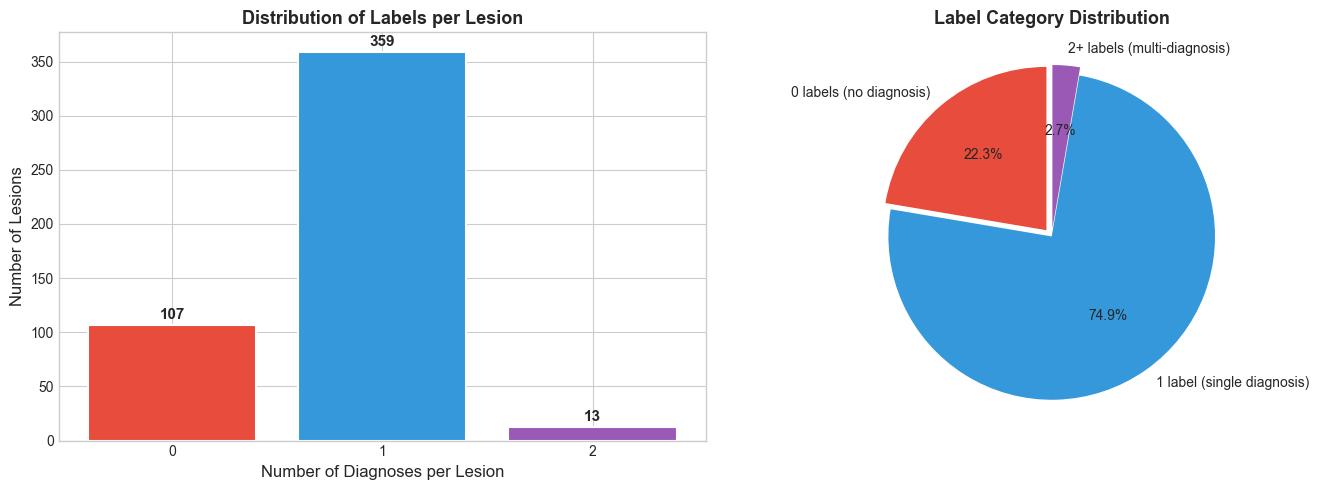


📊 Multi-Label Summary:
Total lesions: 479
Lesions with no diagnosis: 107 (22.3%)
Lesions with single diagnosis: 359 (74.9%)
Lesions with multiple diagnoses: 13 (2.7%)


In [5]:
# Calculate number of labels per lesion
submission_df['num_labels'] = submission_df[DIAGNOSIS_CATEGORIES].sum(axis=1)

# Count distribution
label_counts = submission_df['num_labels'].value_counts().sort_index()

# Create histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Bar chart of label counts
ax1 = axes[0]
colors_hist = ['#e74c3c' if x == 0 else '#3498db' if x == 1 else '#9b59b6' for x in label_counts.index]
bars = ax1.bar(label_counts.index, label_counts.values, color=colors_hist, edgecolor='white', linewidth=1.5)

# Add value labels on bars
for bar, count in zip(bars, label_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{count}', ha='center', fontsize=11, fontweight='bold')

ax1.set_xlabel('Number of Diagnoses per Lesion', fontsize=12)
ax1.set_ylabel('Number of Lesions', fontsize=12)
ax1.set_title('Distribution of Labels per Lesion', fontsize=13, fontweight='bold')
ax1.set_xticks(range(int(submission_df['num_labels'].max()) + 1))

# Right plot: Pie chart
ax2 = axes[1]
label_groups = {
    '0 labels (no diagnosis)': (submission_df['num_labels'] == 0).sum(),
    '1 label (single diagnosis)': (submission_df['num_labels'] == 1).sum(),
    '2+ labels (multi-diagnosis)': (submission_df['num_labels'] >= 2).sum()
}

wedges, texts, autotexts = ax2.pie(
    label_groups.values(), 
    labels=label_groups.keys(),
    autopct='%1.1f%%',
    colors=['#e74c3c', '#3498db', '#9b59b6'],
    explode=(0.05, 0, 0.05),
    startangle=90
)
ax2.set_title('Label Category Distribution', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Multi-Label Summary:")
print(f"Total lesions: {len(submission_df):,}")
print(f"Lesions with no diagnosis: {label_groups['0 labels (no diagnosis)']} ({label_groups['0 labels (no diagnosis)']/len(submission_df)*100:.1f}%)")
print(f"Lesions with single diagnosis: {label_groups['1 label (single diagnosis)']} ({label_groups['1 label (single diagnosis)']/len(submission_df)*100:.1f}%)")
print(f"Lesions with multiple diagnoses: {label_groups['2+ labels (multi-diagnosis)']} ({label_groups['2+ labels (multi-diagnosis)']/len(submission_df)*100:.1f}%)")


In [6]:
# Show lesions with special cases
print("🔍 Lesions with NO predictions (potentially problematic):")
no_pred_lesions = submission_df[submission_df['num_labels'] == 0]['lesion_id'].tolist()
if no_pred_lesions:
    for i, lesion in enumerate(no_pred_lesions[:10]):  # Show first 10
        print(f"  {i+1}. {lesion}")
    if len(no_pred_lesions) > 10:
        print(f"  ... and {len(no_pred_lesions) - 10} more")
else:
    print("  None - all lesions have at least one diagnosis!")

print("\n🔍 Lesions with MULTIPLE predictions:")
multi_pred = submission_df[submission_df['num_labels'] >= 2]
if len(multi_pred) > 0:
    for _, row in multi_pred.head(10).iterrows():
        labels = [cat for cat in DIAGNOSIS_CATEGORIES if row[cat] == 1]
        print(f"  {row['lesion_id']}: {', '.join(labels)}")
    if len(multi_pred) > 10:
        print(f"  ... and {len(multi_pred) - 10} more")
else:
    print("  None - all lesions have single or no diagnosis")


🔍 Lesions with NO predictions (potentially problematic):
  1. IL_0171236
  2. IL_0183960
  3. IL_0207706
  4. IL_0267598
  5. IL_0578791
  6. IL_0649132
  7. IL_0704269
  8. IL_0808321
  9. IL_1011664
  10. IL_1266003
  ... and 97 more

🔍 Lesions with MULTIPLE predictions:
  IL_0344325: BCC, INF
  IL_1248470: BCC, MEL
  IL_1502550: BCC, DF
  IL_1901178: AKIEC, BCC
  IL_2076993: AKIEC, BCC
  IL_3275405: BKL, SCCKA
  IL_4304678: BCC, SCCKA
  IL_4377002: AKIEC, BKL
  IL_5383665: BCC, SCCKA
  IL_5484022: BCC, SCCKA
  ... and 3 more


## 3. Co-occurrence Heatmap

Visualize which diagnosis categories tend to appear together in predictions.


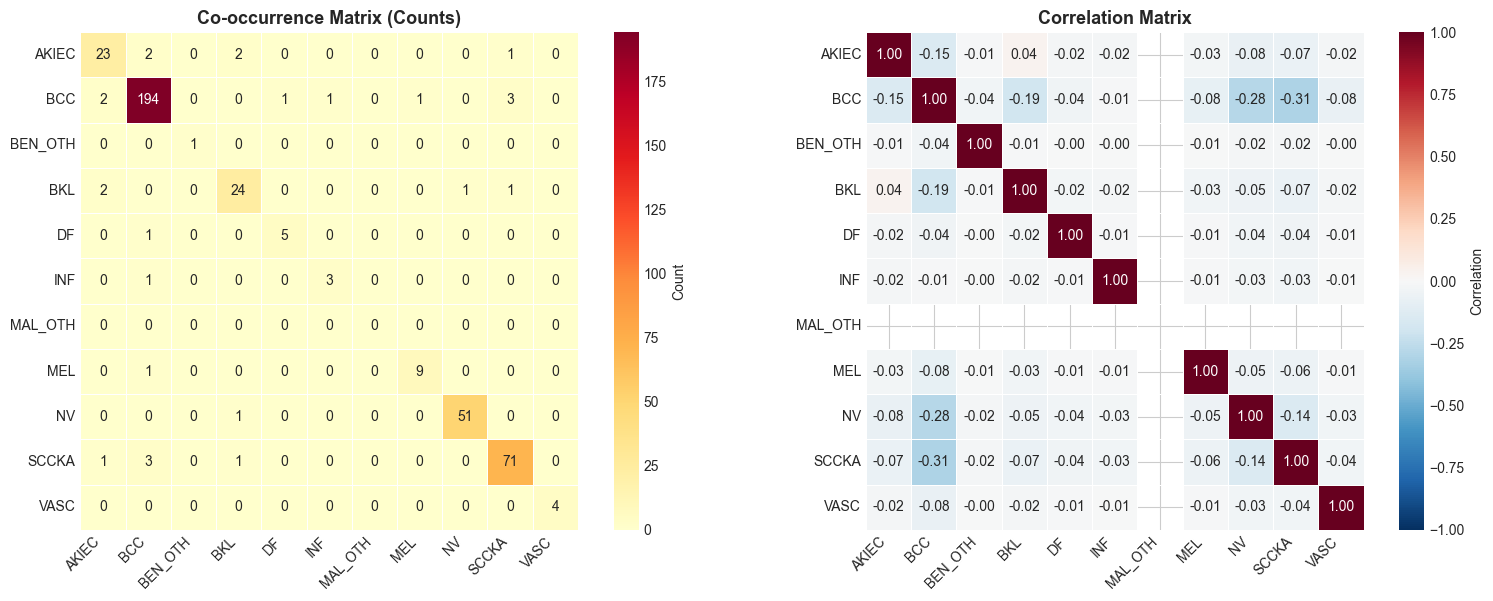


📊 Notable Co-occurrences (excluding same-class):
  AKIEC + BCC: 2 lesions
  AKIEC + BKL: 2 lesions
  AKIEC + SCCKA: 1 lesions
  BCC + DF: 1 lesions
  BCC + INF: 1 lesions
  BCC + MEL: 1 lesions
  BCC + SCCKA: 3 lesions
  BKL + NV: 1 lesions
  BKL + SCCKA: 1 lesions


In [7]:
# Calculate co-occurrence matrix
diagnosis_data = submission_df[DIAGNOSIS_CATEGORIES]

# Method 1: Count-based co-occurrence (how many times two classes appear together)
cooccurrence_matrix = np.zeros((len(DIAGNOSIS_CATEGORIES), len(DIAGNOSIS_CATEGORIES)))

for i, cat1 in enumerate(DIAGNOSIS_CATEGORIES):
    for j, cat2 in enumerate(DIAGNOSIS_CATEGORIES):
        cooccurrence_matrix[i, j] = ((diagnosis_data[cat1] == 1) & (diagnosis_data[cat2] == 1)).sum()

cooccurrence_df = pd.DataFrame(
    cooccurrence_matrix,
    index=DIAGNOSIS_CATEGORIES,
    columns=DIAGNOSIS_CATEGORIES
)

# Create heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Co-occurrence counts
ax1 = axes[0]
mask = np.triu(np.ones_like(cooccurrence_df, dtype=bool), k=1)  # Upper triangle mask
sns.heatmap(
    cooccurrence_df, 
    ax=ax1,
    annot=True, 
    fmt='.0f',
    cmap='YlOrRd',
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Count'}
)
ax1.set_title('Co-occurrence Matrix (Counts)', fontsize=13, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Right: Correlation matrix
ax2 = axes[1]
correlation_matrix = diagnosis_data.corr()
sns.heatmap(
    correlation_matrix, 
    ax=ax2,
    annot=True, 
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=0.5,
    vmin=-1, vmax=1,
    cbar_kws={'label': 'Correlation'}
)
ax2.set_title('Correlation Matrix', fontsize=13, fontweight='bold')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print notable co-occurrences (excluding diagonal)
print("\n📊 Notable Co-occurrences (excluding same-class):")
for i, cat1 in enumerate(DIAGNOSIS_CATEGORIES):
    for j, cat2 in enumerate(DIAGNOSIS_CATEGORIES):
        if i < j and cooccurrence_matrix[i, j] > 0:
            print(f"  {cat1} + {cat2}: {int(cooccurrence_matrix[i, j])} lesions")


## 4. Sample Images with Predictions

Display sample lesion images (clinical and dermoscopic pairs) along with their predicted diagnoses.


In [8]:
# Load test metadata to get image paths
test_metadata_path = DATASET_DIR / 'MILK10k_Test_Metadata.csv'

if test_metadata_path.exists():
    test_metadata = pd.read_csv(test_metadata_path)
    print(f"Loaded test metadata: {len(test_metadata)} rows")
    print(f"Columns: {list(test_metadata.columns)}")
    
    # Create a mapping from lesion_id to image paths
    lesion_images = {}
    for lesion_id, group in test_metadata.groupby('lesion_id'):
        clinical_row = group[group['image_type'] == 'clinical: close-up']
        dermoscopic_row = group[group['image_type'] == 'dermoscopic']
        
        if len(clinical_row) > 0 and len(dermoscopic_row) > 0:
            clinical_path = TEST_INPUT_DIR / lesion_id / f"{clinical_row.iloc[0]['isic_id']}.jpg"
            dermoscopic_path = TEST_INPUT_DIR / lesion_id / f"{dermoscopic_row.iloc[0]['isic_id']}.jpg"
            lesion_images[lesion_id] = {
                'clinical': clinical_path,
                'dermoscopic': dermoscopic_path
            }
    
    print(f"Mapped {len(lesion_images)} lesions with image paths")
else:
    print(f"Test metadata not found at {test_metadata_path}")
    print("Will attempt to load images directly from directory structure...")
    lesion_images = {}
    
    # Fallback: load from directory structure
    if TEST_INPUT_DIR.exists():
        for lesion_dir in TEST_INPUT_DIR.iterdir():
            if lesion_dir.is_dir() and lesion_dir.name.startswith('IL_'):
                images = sorted(list(lesion_dir.glob('*.jpg')))
                if len(images) >= 2:
                    lesion_images[lesion_dir.name] = {
                        'clinical': images[0],  # Note: order may not be correct without metadata
                        'dermoscopic': images[1]
                    }
        print(f"Found {len(lesion_images)} lesions from directory structure")


Loaded test metadata: 958 rows
Columns: ['lesion_id', 'image_type', 'isic_id', 'attribution', 'copyright_license', 'image_manipulation', 'age_approx', 'sex', 'skin_tone_class', 'site', 'MONET_ulceration_crust', 'MONET_hair', 'MONET_vasculature_vessels', 'MONET_erythema', 'MONET_pigmented', 'MONET_gel_water_drop_fluid_dermoscopy_liquid', 'MONET_skin_markings_pen_ink_purple_pen']
Mapped 479 lesions with image paths


📸 Random Sample of Predictions:


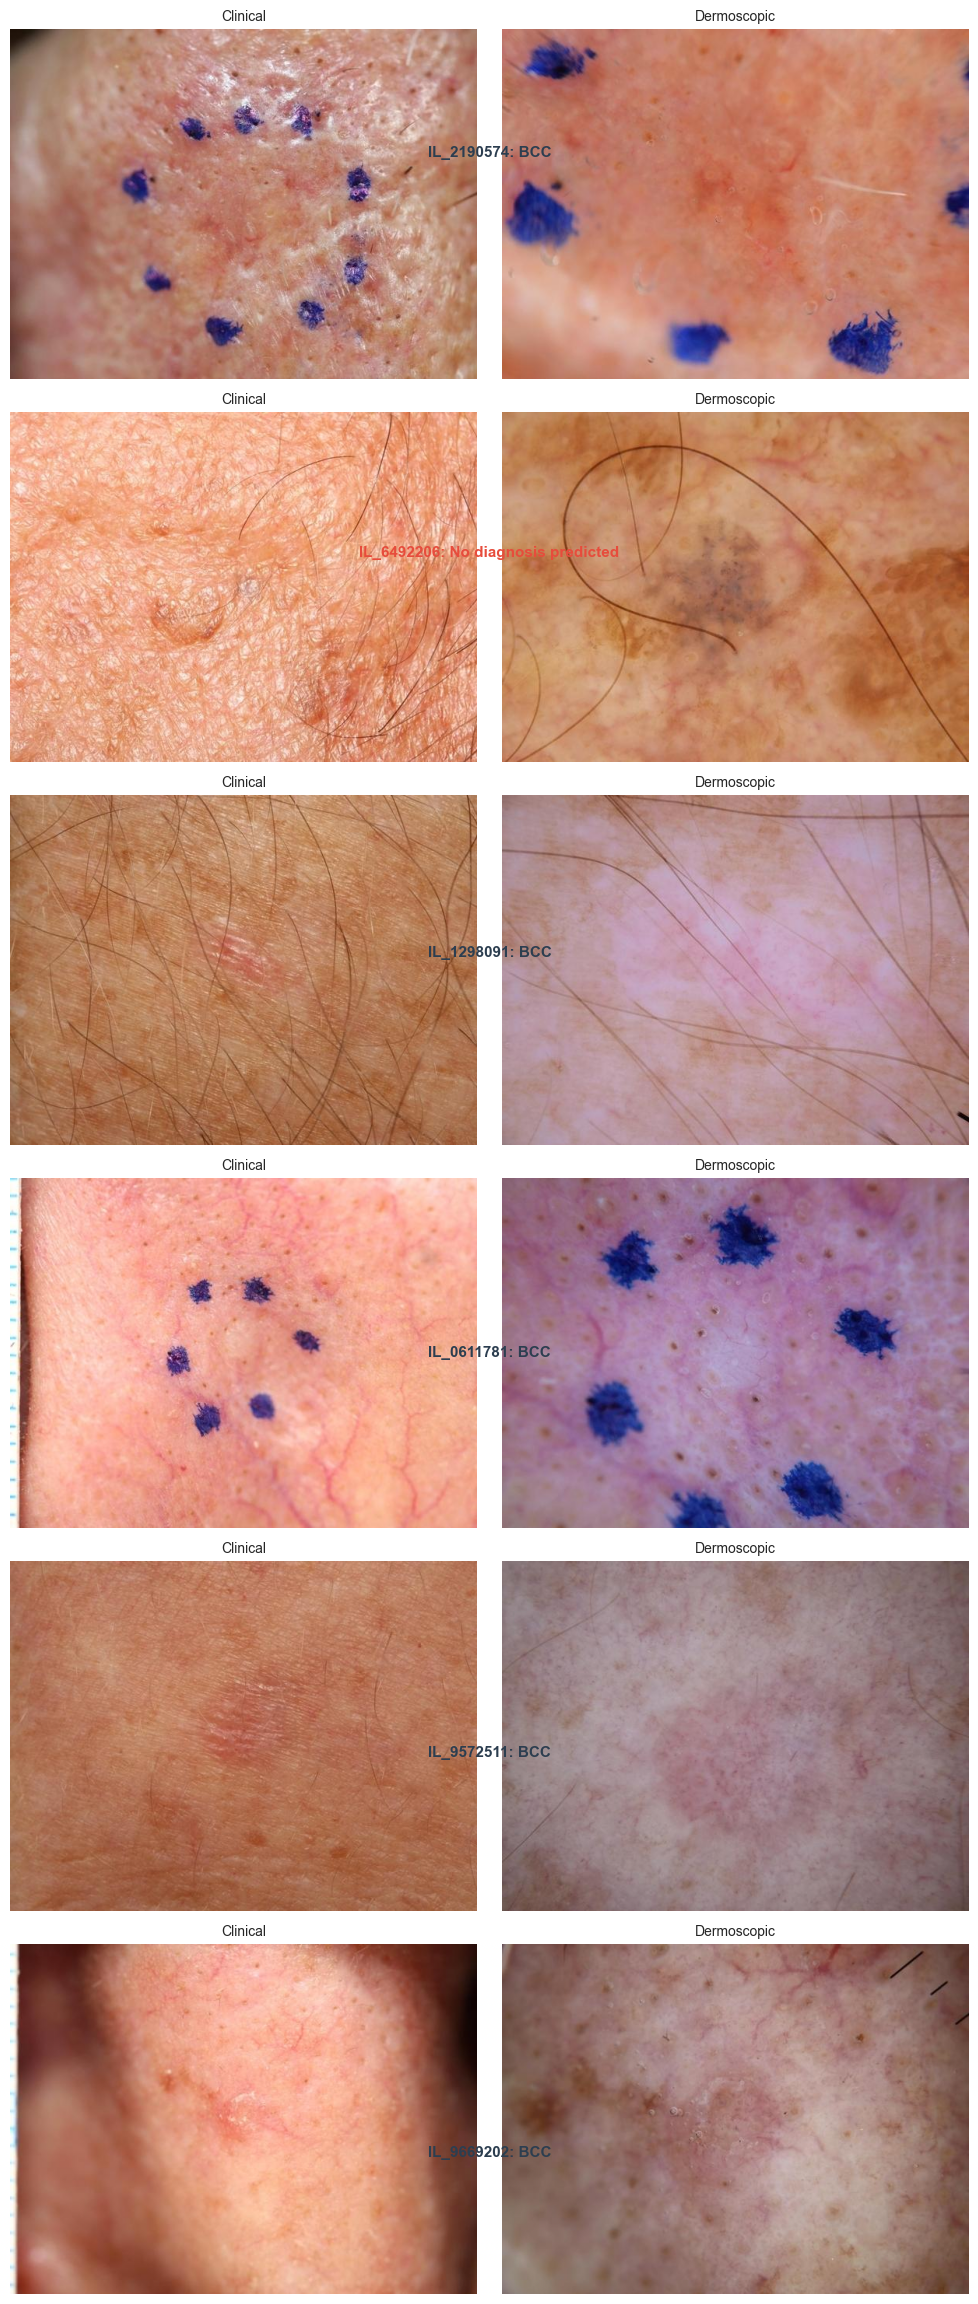

In [9]:
def display_sample_predictions(submission_df, lesion_images, n_samples=6, random_state=42):
    """Display sample images with their predicted labels"""
    
    # Filter to lesions we have images for
    available_lesions = [lid for lid in submission_df['lesion_id'] if lid in lesion_images]
    
    if len(available_lesions) == 0:
        print("No images available for display.")
        return
    
    # Sample lesions
    np.random.seed(random_state)
    sample_lesions = np.random.choice(available_lesions, min(n_samples, len(available_lesions)), replace=False)
    
    # Create figure
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 4 * n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, lesion_id in enumerate(sample_lesions):
        # Get predictions for this lesion
        row = submission_df[submission_df['lesion_id'] == lesion_id].iloc[0]
        predicted_labels = [cat for cat in DIAGNOSIS_CATEGORIES if row[cat] == 1]
        
        # Format prediction text
        if predicted_labels:
            pred_text = ', '.join(predicted_labels)
        else:
            pred_text = 'No diagnosis predicted'
        
        # Load images
        paths = lesion_images[lesion_id]
        
        try:
            clinical_img = Image.open(paths['clinical'])
            dermoscopic_img = Image.open(paths['dermoscopic'])
            
            # Display clinical image
            axes[idx, 0].imshow(clinical_img)
            axes[idx, 0].set_title(f'Clinical', fontsize=10)
            axes[idx, 0].axis('off')
            
            # Display dermoscopic image
            axes[idx, 1].imshow(dermoscopic_img)
            axes[idx, 1].set_title(f'Dermoscopic', fontsize=10)
            axes[idx, 1].axis('off')
            
            # Add lesion ID and prediction as suptitle for the row
            fig.text(0.5, 1 - (idx + 0.5) / n_samples - 0.02, 
                     f'{lesion_id}: {pred_text}', 
                     ha='center', fontsize=11, fontweight='bold',
                     color='#2c3e50' if predicted_labels else '#e74c3c')
            
        except Exception as e:
            axes[idx, 0].text(0.5, 0.5, f'Error loading image:\n{str(e)[:50]}', 
                            ha='center', va='center', transform=axes[idx, 0].transAxes)
            axes[idx, 0].axis('off')
            axes[idx, 1].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Display samples
if lesion_images:
    print("📸 Random Sample of Predictions:")
    display_sample_predictions(submission_df, lesion_images, n_samples=6)
else:
    print("⚠️ Cannot display images - no image paths available")



📸 One Example from Each Predicted Class:


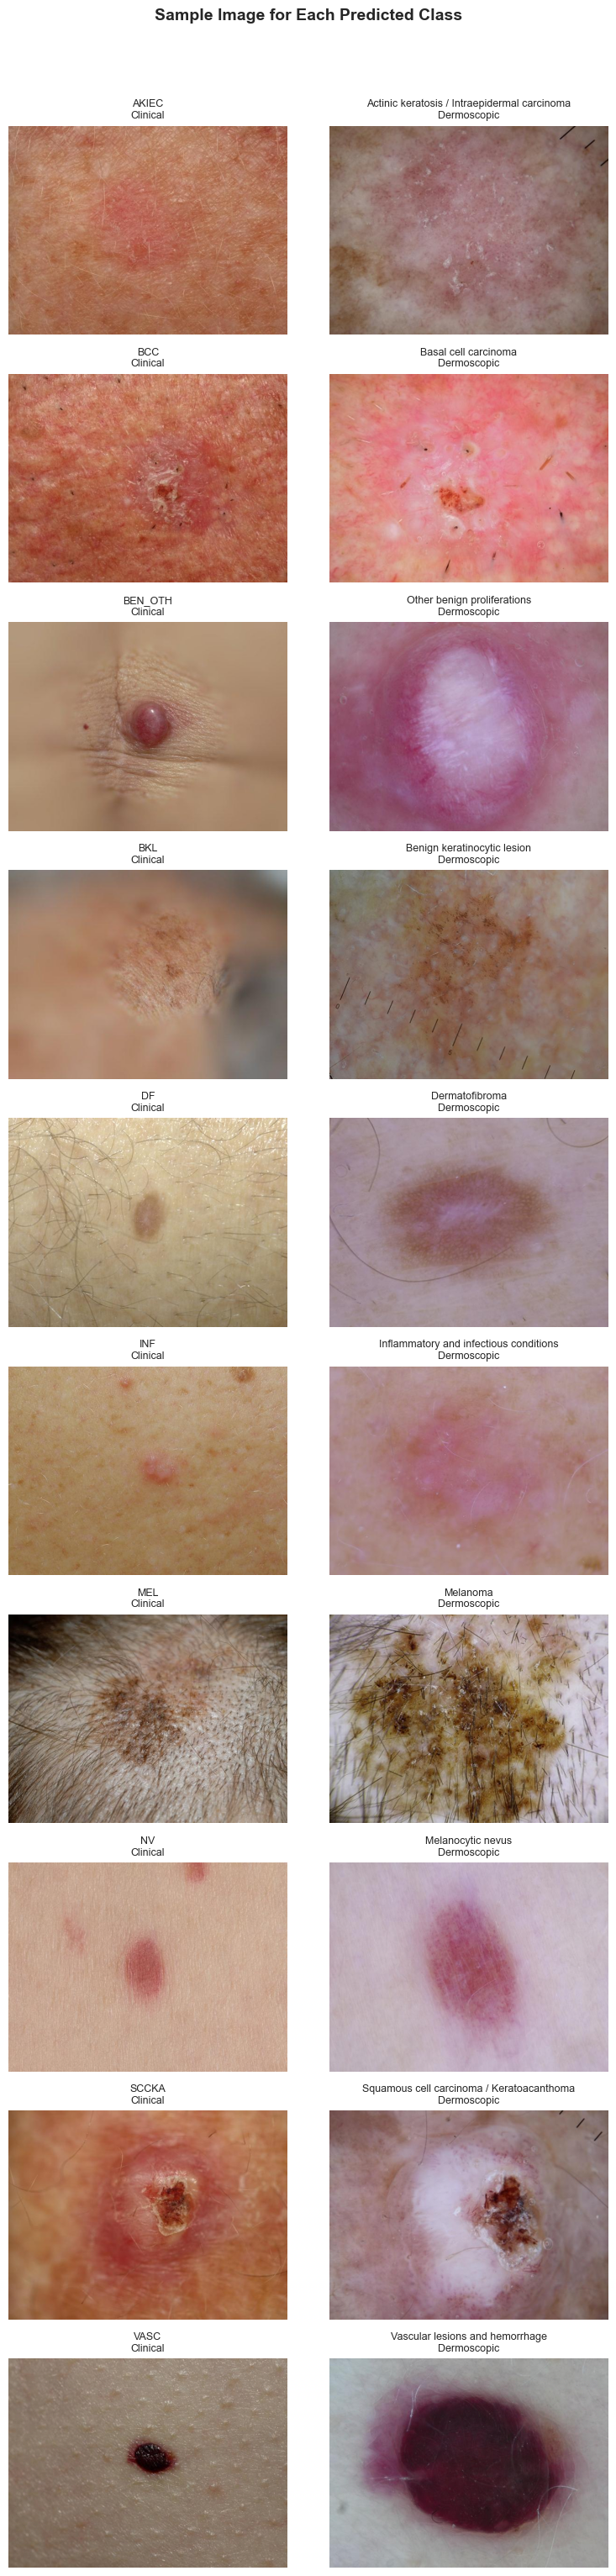

In [10]:
# Display one sample from each predicted class
def display_class_examples(submission_df, lesion_images):
    """Display one example from each predicted class"""
    
    # Find classes that have at least one prediction
    classes_with_predictions = [cat for cat in DIAGNOSIS_CATEGORIES 
                                 if submission_df[cat].sum() > 0]
    
    if not classes_with_predictions:
        print("No classes with predictions found.")
        return
    
    n_classes = len(classes_with_predictions)
    fig, axes = plt.subplots(n_classes, 2, figsize=(8, 3 * n_classes))
    if n_classes == 1:
        axes = axes.reshape(1, -1)
    
    for idx, diagnosis_class in enumerate(classes_with_predictions):
        # Find a lesion with this class prediction
        class_lesions = submission_df[submission_df[diagnosis_class] == 1]['lesion_id'].tolist()
        available = [lid for lid in class_lesions if lid in lesion_images]
        
        if not available:
            axes[idx, 0].text(0.5, 0.5, f'No images for {diagnosis_class}', 
                            ha='center', va='center', transform=axes[idx, 0].transAxes)
            axes[idx, 0].axis('off')
            axes[idx, 1].axis('off')
            continue
        
        lesion_id = available[0]
        paths = lesion_images[lesion_id]
        
        try:
            clinical_img = Image.open(paths['clinical'])
            dermoscopic_img = Image.open(paths['dermoscopic'])
            
            axes[idx, 0].imshow(clinical_img)
            axes[idx, 0].set_title(f'{diagnosis_class}\nClinical', fontsize=9)
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(dermoscopic_img)
            axes[idx, 1].set_title(f'{DIAGNOSIS_FULL_NAMES[diagnosis_class]}\nDermoscopic', fontsize=9)
            axes[idx, 1].axis('off')
            
        except Exception as e:
            axes[idx, 0].text(0.5, 0.5, f'Error: {str(e)[:30]}', 
                            ha='center', va='center', transform=axes[idx, 0].transAxes)
            axes[idx, 0].axis('off')
            axes[idx, 1].axis('off')
    
    plt.suptitle('Sample Image for Each Predicted Class', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Display class examples
if lesion_images:
    print("\n📸 One Example from Each Predicted Class:")
    display_class_examples(submission_df, lesion_images)


## Summary

This notebook visualized:
1. **Class Distribution**: Bar chart showing prediction counts per diagnosis category
2. **Multi-label Analysis**: Distribution of how many diagnoses each lesion received
3. **Co-occurrence Patterns**: Heatmaps showing which diagnoses tend to appear together
4. **Sample Images**: Visual examples of lesions with their predicted labels


In [11]:
# Final summary statistics
print("=" * 50)
print("📊 SUBMISSION SUMMARY")
print("=" * 50)
print(f"\n📁 File: {submission_path}")
print(f"📋 Total lesions: {len(submission_df):,}")
print(f"\n🏥 Predictions by category:")

# Sort by count descending
sorted_counts = submission_df[DIAGNOSIS_CATEGORIES].sum().sort_values(ascending=False)
for cls, count in sorted_counts.items():
    pct = count / len(submission_df) * 100
    category_type = "🔴" if cls in MALIGNANT_CLASSES else "🟢" if cls in BENIGN_CLASSES else "🟠"
    print(f"   {category_type} {cls}: {int(count):>4} ({pct:>5.1f}%)")

print(f"\n📈 Multi-label statistics:")
print(f"   Lesions with 0 labels: {(submission_df['num_labels'] == 0).sum()}")
print(f"   Lesions with 1 label: {(submission_df['num_labels'] == 1).sum()}")
print(f"   Lesions with 2+ labels: {(submission_df['num_labels'] >= 2).sum()}")

print("\n" + "=" * 50)
print("✅ Visualization complete!")
print("=" * 50)


📊 SUBMISSION SUMMARY

📁 File: d:\PYTHON\DEEP_LEARNING\notebooks\..\results\submission.csv
📋 Total lesions: 479

🏥 Predictions by category:
   🔴 BCC:  194 ( 40.5%)
   🔴 SCCKA:   71 ( 14.8%)
   🟢 NV:   51 ( 10.6%)
   🟢 BKL:   24 (  5.0%)
   🔴 AKIEC:   23 (  4.8%)
   🔴 MEL:    9 (  1.9%)
   🟢 DF:    5 (  1.0%)
   🟢 VASC:    4 (  0.8%)
   🟠 INF:    3 (  0.6%)
   🟢 BEN_OTH:    1 (  0.2%)
   🔴 MAL_OTH:    0 (  0.0%)

📈 Multi-label statistics:
   Lesions with 0 labels: 107
   Lesions with 1 label: 359
   Lesions with 2+ labels: 13

✅ Visualization complete!


## 5. Prediction Quality Analysis

Analyze the quality and confidence of predictions.


In [ ]:
# Analyze prediction patterns
print("📊 Prediction Quality Analysis")
print("=" * 50)

# Calculate prediction patterns
total_lesions = len(submission_df)
total_predictions = submission_df[DIAGNOSIS_CATEGORIES].sum().sum()
avg_predictions_per_lesion = total_predictions / total_lesions

print(f"\n📈 Prediction Statistics:")
print(f"   Total lesions: {total_lesions}")
print(f"   Total positive predictions: {int(total_predictions)}")
print(f"   Avg predictions per lesion: {avg_predictions_per_lesion:.2f}")

# Analyze lesions with no predictions (potential issues)
no_pred_count = (submission_df['num_labels'] == 0).sum()
single_pred_count = (submission_df['num_labels'] == 1).sum()
multi_pred_count = (submission_df['num_labels'] >= 2).sum()

print(f"\n🔍 Prediction Coverage:")
print(f"   Lesions with no diagnosis: {no_pred_count} ({no_pred_count/total_lesions*100:.1f}%)")
print(f"   Lesions with single diagnosis: {single_pred_count} ({single_pred_count/total_lesions*100:.1f}%)")
print(f"   Lesions with multiple diagnoses: {multi_pred_count} ({multi_pred_count/total_lesions*100:.1f}%)")

# Check for class imbalance in predictions
pred_counts = submission_df[DIAGNOSIS_CATEGORIES].sum()
max_pred_class = pred_counts.idxmax()
min_pred_class = pred_counts[pred_counts > 0].idxmin() if (pred_counts > 0).any() else 'None'

print(f"\n⚖️ Prediction Balance:")
print(f"   Most predicted class: {max_pred_class} ({int(pred_counts[max_pred_class])} predictions)")
if min_pred_class != 'None':
    print(f"   Least predicted class (non-zero): {min_pred_class} ({int(pred_counts[min_pred_class])} predictions)")

# Classes with no predictions (potential issue)
zero_pred_classes = [cat for cat in DIAGNOSIS_CATEGORIES if pred_counts[cat] == 0]
if zero_pred_classes:
    print(f"\n⚠️ Classes with NO predictions: {', '.join(zero_pred_classes)}")
    print("   (This may indicate model issues for these rare classes)")

print("=" * 50)


In [ ]:
# Visualize prediction distribution as pie chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Class distribution pie chart
ax1 = axes[0]
pred_counts_nonzero = pred_counts[pred_counts > 0]
colors = ['#e74c3c' if cat in MALIGNANT_CLASSES else '#27ae60' if cat in BENIGN_CLASSES else '#f39c12' 
          for cat in pred_counts_nonzero.index]

wedges, texts, autotexts = ax1.pie(
    pred_counts_nonzero.values,
    labels=pred_counts_nonzero.index,
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.02] * len(pred_counts_nonzero),
    startangle=90
)
ax1.set_title('Prediction Distribution by Class', fontsize=12, fontweight='bold')

# Right: Lesion coverage
ax2 = axes[1]
coverage_data = {
    'No Diagnosis': no_pred_count,
    'Single Diagnosis': single_pred_count,
    'Multiple Diagnoses': multi_pred_count
}
colors_coverage = ['#e74c3c', '#3498db', '#9b59b6']
wedges2, texts2, autotexts2 = ax2.pie(
    coverage_data.values(),
    labels=coverage_data.keys(),
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total_lesions)})',
    colors=colors_coverage,
    explode=[0.05, 0, 0.05],
    startangle=90
)
ax2.set_title('Lesion Coverage Analysis', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'prediction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Chart saved to: {RESULTS_DIR / 'prediction_distribution.png'}")


## 6. Next Steps

### For Full Evaluation Metrics

This notebook shows **submission predictions** for the blind test set. Since there are no ground truth labels for the test set, actual performance metrics (F1, Precision, Recall, AUC) can only be obtained by:

1. **Submitting to ISIC Leaderboard**: Upload `submission.csv` to https://challenge.isic-archive.com/landing/milk10k/
2. **Running Validation Evaluation**: Use `03_Model_Evaluation.ipynb` to see metrics on the validation set

### Available in `03_Model_Evaluation.ipynb`:
- Macro F1 Score (primary ISIC metric)
- Per-class F1, Precision, Recall
- ROC curves and AUC-ROC scores
- Confusion matrices
- Training history analysis
- Error analysis with sample images

---

**Primary Metric**: The MILK10k challenge uses **Macro F1 Score** with threshold ≥ 0.5 as the evaluation metric.
